# Solution for Homework 3

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Copy functions from Class Notebook

In [13]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [14]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [15]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [19]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

## Problem 3: Spectrum of raised cosine pulse

Plot the PSD of a linearly modulated signal when raised cosine pulses are used for pulse shaping. Use the same roll-off factors as in the plot above. Remember that the PSD is proportional to $|H_{RC}(f)|^2$. Use a normalized frequency axis that spans from $-2 \leq fT \leq 2$.



**Answer:** The notebook gives an expression for the Fourier transform of the raised cosine pulse:
$$
H_{RC}(f) = \begin{cases}
    T & |fT| \leq \frac{1-a}{2} \\
    \frac{T}{2}(1 - \sin(\frac{\pi T}{a}(|f|-\frac{1}{2T}))) & \frac{1-a}{2} \leq |fT| \leq \frac{1+a}{2} \\
    0 & |fT| >  \frac{1+a}{2}
\end{cases}
$$
Here is a function for computing $_{RC}(f)$.

In [11]:
def H_RC(f, alpha, T=1.0):
    """Compute the Fourier Transform of a Raised Cosine Pulse
    
    Inputs:
    f - vector of frequencies to compute H_RC for
    alpha - roll-off factor
    T - symbol period (default: 1.0)

    Returns:
    Vector containing frequency response
    """
    fT = f*T
    H = np.zeros_like(fT)

    for n in range(len(fT)):
        if np.abs(fT[n]) <= (1-alpha)/2:
            H[n] = T
        elif np.abs(fT[n]) <= (1+alpha)/2:
            H[n] = T/2 * (1 - np.sin(np.pi/alpha * (np.abs(fT[n]) - 0.5) ) )
        else:
            H[n] = 0

    return H            

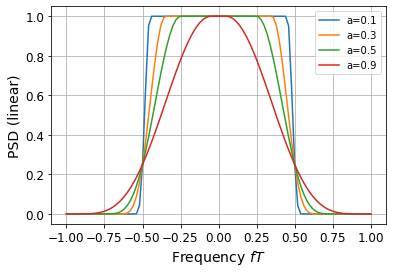

In [12]:
ff = np.linspace(-1, 1, 101)

for a in [0.1, 0.3, 0.5, 0.9]:
    plt.plot(ff, H_RC(ff, a, 1)**2, label='a={:3.1f}'.format(a))
plt.grid()
plt.xlabel('Frequency $fT$')
plt.ylabel('PSD (linear)')
plt.legend()

plt.show()

## Problem 4: Timing Error

Expand on the Monte Carlo Simulation at the end of the  Notebook on Pulse Shaping.
The objective is to evaluate that an error in sample timing has on the symbol error rate.

To simulate a timing error, change the sampling instances by changing the code line
``` Python
Z = mf_out[d_samples::fsT]
```
to
``` Python
Z = mf_out[d_samples+e::fsT]
```      
where `e` is the timing error in sample periods.
Thus, `e = 1` corresponds to a timing error of
$\frac{1}{\text{fsT}}$ ymbol periods
    
1. Initially, use the same parameters as in the notebook:
    * oversampling factor `fsT = 16`
    * SRRC roll-off factor `a = 0.5`
    * and SNR `SNR_dB = 10`.  
Via Monte Carlo simulation, measure the symbol error rate for
timing errors ranging from `e=-8` to `e=8`
samples.  
Plot the symbol error rate over the timing error.
2. Repeat the above experiment for roll-off factors $a=0.1$ and $a=0.9$.
3. Analyze and summarize your findings from this experiment.


**Answer:** The first part is straightforward

In [39]:
# parameters
fsT = 16
Np = 5
a = 0.5

pp = srrc_pulse(a, fsT, Np)   # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1      # filter delay
SNR_dB = 10
SNR = 10**(SNR_dB/10)
A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
N = 1024                    # number of symbols per burst

e_vec = np.arange(-8, 9)

# simulation parameters
max_bursts = 1000
max_errors = 400

# storage for results
P_MC = np.zeros_like(e_vec, dtype=float)

In [40]:
for n in range(len(e_vec)):
    N_bursts = 0
    N_errors = 0
    e = e_vec[n]
    # the Monte Carlo loop
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        ss = pulse_shape(sym, pp, fsT)
        # Channel
        rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # receiver
        mf_out = np.convolve(rr, np.flip(pp))
        Z = mf_out[d_samples+e::fsT]        # down-sample, starting at filter delay
        dec = MPE_decision_rule(Z[:N], A) # Z[:N] trims extra samples from the filter transisent

        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))

    P_MC[n] = N_errors/(N*N_bursts)

    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, P_MC[n]))
    

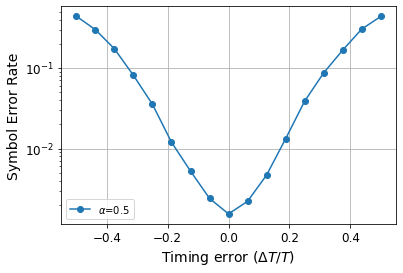

In [41]:
plt.semilogy(e_vec/fsT, P_MC, '-o', label=r'$\alpha$={:3.1f}'.format(a))
plt.grid()

plt.xlabel('Timing error ($\Delta T/T$)')
plt.ylabel('Symbol Error Rate')
plt.legend()

plt.show()

For the remaining parts, we wrap another loop around the two that are alreaady there.

In [43]:
# Parameters: Specify all values of alpha we want and create enough storage to hold all results
a_vec = [0.1, 0.5, 0.9]

# storage for results
P_MC = np.zeros((len(a_vec), len(e_vec)), dtype=float)

In [46]:
for m in range(len(a_vec)):
    a = a_vec[m]
    pp = srrc_pulse(a, fsT, Np)

    for n in range(len(e_vec)):
        N_bursts = 0
        N_errors = 0
        e = e_vec[n]
        
        # the Monte Carlo loop
        while N_bursts < max_bursts and N_errors < max_errors:
            # Transmitter
            sym = random_symbols(A, N)
            ss = pulse_shape(sym, pp, fsT)
            # Channel
            rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
            # receiver
            mf_out = np.convolve(rr, np.flip(pp))
            Z = mf_out[d_samples+e::fsT]        # down-sample, starting at filter delay
            dec = MPE_decision_rule(Z[:N], A) # Z[:N] trims extra samples from the filter transisent

            # update simulation statistics
            N_bursts += 1
            N_errors += np.sum(np.not_equal(dec, sym))

        P_MC[m, n] = N_errors/(N*N_bursts)

        # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, P_MC[m,n]))
    

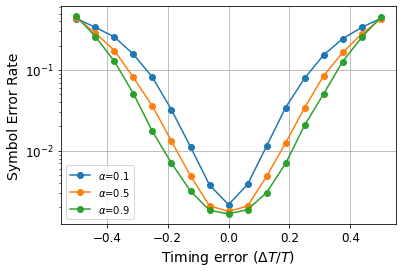

In [45]:
for m in range(len(a_vec)):
    a = a_vec[m]
    plt.semilogy(e_vec/fsT, P_MC[m,:], '-o', label=r'$\alpha$={:3.1f}'.format(a))
plt.grid()

plt.xlabel('Timing error ($\Delta T/T$)')
plt.ylabel('Symbol Error Rate')
plt.legend()

plt.show()

The error rate is very susceptible to timing error. As the timing error approaches $T/2$, error rate approaches 0.5 regardless of the roll-off factor. Similarly,  for perfect timing, performance is identical (to within the simulation accuracy) for all values of the roll-off factor.

However, for small timing errors the performance with larger vlaues of $\alpha$ holds up much better. Both $\alpha=0.5$ and $\alpha=0.9$ show very little performance loss when the timing error is $T/16$.